In [ ]:
import matplotlib

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.0


In [ ]:
# Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
!pip install -U matplotlib

exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 16.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
time: 369 µs (started: 2023-02-15 21:41:01 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.43 s (started: 2023-02-15 21:41:05 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

# print('versión TF:', tf.__version__) # versión TF: 2.8.0
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

versión Keras: 2.11.0
time: 1.2 ms (started: 2023-02-15 21:41:09 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 22 s (started: 2023-02-15 21:41:18 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_8G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model: Modelo de Deep Learning
        -TYPE_IMG: regular o inverted
    '''
    MODEL_NAME = f'model_resnet152V2_etl8_imgs{SIZE}_'+ TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print('------ Model Saved -------')


time: 7.53 ms (started: 2023-02-15 21:41:46 +00:00)


# Imgs 64x64

- Test Accuracy: 0.6850676536560059
- Test Loss: 1.485365629196167
- time: 1h 15min 7s
- F1 score: 0.6849593312844126
- Precision score: 0.7007262458066756
- Recall:  0.685067681895093
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 579 µs (started: 2023-02-15 21:41:56 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 11.4 s (started: 2023-02-15 21:41:57 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.5 ms (started: 2023-02-15 21:42:08 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 7s 0us/step
time: 15.4 s (started: 2023-02-15 21:42:08 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 111s 28ms/step - loss: 5.5729 - sparse_categorical_accuracy: 0.1210 - val_loss: 4.8655 - val_sparse_categorical_accuracy: 0.2228
Epoch 2/50
3325/3325 [==============================] - 92s 28ms/step - loss: 4.3698 - sparse_categorical_accuracy: 0.3305 - val_loss: 4.1642 - val_sparse_categorical_accuracy: 0.3397
Epoch 3/50
3325/3325 [==============================] - 91s 28ms/step - loss: 3.7394 - sparse_categorical_accuracy: 0.4310 - val_loss: 3.7160 - val_sparse_categorical_accuracy: 0.3962
Epoch 4/50
3325/3325 [==============================] - 90s 27ms/step - loss: 3.2998 - sparse_categorical_accuracy: 0.4923 - val_loss: 3.3906 - val_sparse_categorical_accuracy: 0.4387
Epoch 5/50
3325/3325 [==============================] - 90s 27ms/step - loss: 2.9670 - sparse_categorical_accuracy: 0.5375 - val_loss: 3.1410 - val_sparse_categorical_accuracy: 0.4688
Epoch 6/50
3325/3325 [==============================] - 90s 27ms/step - loss: 2

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.73 s (started: 2023-02-15 22:57:33 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 13s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6850676536560059
- Test Loss: 1.485365629196167
- time: 
- F1 score: 0.6849593312844126
- Precision score: 0.7007262458066756
- Recall:  0.685067681895093
- Epoch: 
*********************************************************************************************************************************
time: 24.2 s (started: 2023-02-15 22:57:35 +00:00)


## Graficando

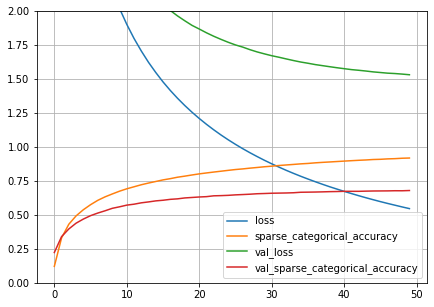

time: 270 ms (started: 2023-02-15 22:57:59 +00:00)


In [ ]:
plot_loss(history)

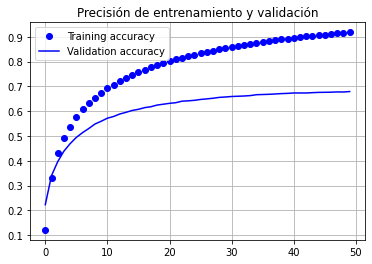

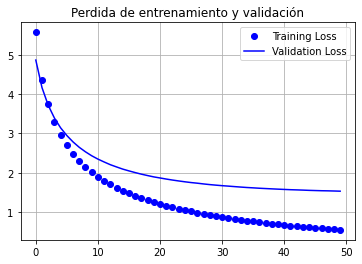

time: 386 ms (started: 2023-02-15 22:58:00 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 2.36 s (started: 2023-02-15 22:58:00 +00:00)


# Imgs 96x96

- Test Accuracy: 0.7547941207885742
- Test Loss: 1.197361707687378
- time: 1h 20min 44s
- F1 score: 0.7546963681200194
- Precision score: 0.768564999231015
- Recall:  0.7547941342357586
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 963 µs (started: 2023-02-15 22:59:54 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 15.3 s (started: 2023-02-15 22:59:55 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 1.07 ms (started: 2023-02-15 23:00:10 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.4 s (started: 2023-02-15 23:00:10 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 109s 30ms/step - loss: 5.6772 - sparse_categorical_accuracy: 0.1153 - val_loss: 5.0023 - val_sparse_categorical_accuracy: 0.2195
Epoch 2/50
3325/3325 [==============================] - 98s 29ms/step - loss: 4.5198 - sparse_categorical_accuracy: 0.3256 - val_loss: 4.3030 - val_sparse_categorical_accuracy: 0.3458
Epoch 3/50
3325/3325 [==============================] - 98s 30ms/step - loss: 3.8855 - sparse_categorical_accuracy: 0.4307 - val_loss: 3.8333 - val_sparse_categorical_accuracy: 0.4102
Epoch 4/50
3325/3325 [==============================] - 97s 29ms/step - loss: 3.4282 - sparse_categorical_accuracy: 0.4997 - val_loss: 3.4844 - val_sparse_categorical_accuracy: 0.4537
Epoch 5/50
3325/3325 [==============================] - 96s 29ms/step - loss: 3.0731 - sparse_categorical_accuracy: 0.5527 - val_loss: 3.2083 - val_sparse_categorical_accuracy: 0.4947
Epoch 6/50
3325/3325 [==============================] - 97s 29ms/step - loss: 2

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.74 s (started: 2023-02-16 00:21:01 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 13s 23ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7547941207885742
- Test Loss: 1.197361707687378
- time: 
- F1 score: 0.7546963681200194
- Precision score: 0.768564999231015
- Recall:  0.7547941342357586
- Epoch: 
*********************************************************************************************************************************
time: 25.3 s (started: 2023-02-16 00:21:04 +00:00)


## Graficando

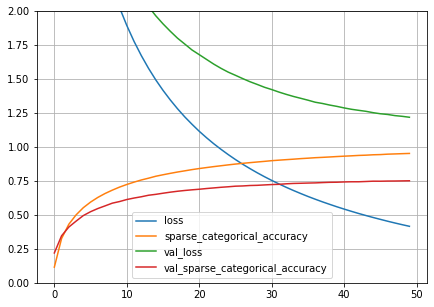

time: 217 ms (started: 2023-02-16 00:21:29 +00:00)


In [ ]:
plot_loss(history)

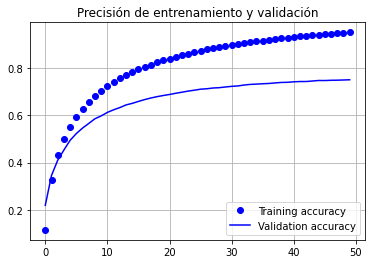

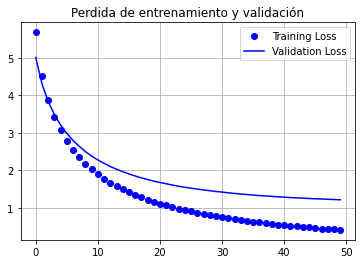

time: 365 ms (started: 2023-02-16 00:21:29 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 1.63 s (started: 2023-02-16 00:21:30 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7752397060394287
- Test Loss: 1.0382981300354004
- time: 1h 26min 3s
- F1 score: 0.7754199999951884
- Precision score: 0.7882837113309368
- Recall:  0.7752397067117879
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 630 µs (started: 2023-02-16 00:21:32 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 20.8 s (started: 2023-02-16 00:21:32 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.6 ms (started: 2023-02-16 00:21:52 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 5.13 s (started: 2023-02-16 00:21:52 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 115s 32ms/step - loss: 5.3908 - sparse_categorical_accuracy: 0.1414 - val_loss: 4.5881 - val_sparse_categorical_accuracy: 0.2641
Epoch 2/50
3325/3325 [==============================] - 107s 32ms/step - loss: 4.0635 - sparse_categorical_accuracy: 0.3693 - val_loss: 3.8104 - val_sparse_categorical_accuracy: 0.3903
Epoch 3/50
3325/3325 [==============================] - 107s 32ms/step - loss: 3.3760 - sparse_categorical_accuracy: 0.4813 - val_loss: 3.3158 - val_sparse_categorical_accuracy: 0.4595
Epoch 4/50
3325/3325 [==============================] - 107s 32ms/step - loss: 2.9030 - sparse_categorical_accuracy: 0.5556 - val_loss: 2.9637 - val_sparse_categorical_accuracy: 0.5092
Epoch 5/50
3325/3325 [==============================] - 108s 32ms/step - loss: 2.5504 - sparse_categorical_accuracy: 0.6094 - val_loss: 2.6932 - val_sparse_categorical_accuracy: 0.5478
Epoch 6/50
3325/3325 [==============================] - 109s 33ms/step - lo

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.06 s (started: 2023-02-16 01:48:04 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 13s 24ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7752397060394287
- Test Loss: 1.0382981300354004
- time: 
- F1 score: 0.7754199999951884
- Precision score: 0.7882837113309368
- Recall:  0.7752397067117879
- Epoch: 
*********************************************************************************************************************************
time: 26.3 s (started: 2023-02-16 01:48:07 +00:00)


## Graficando

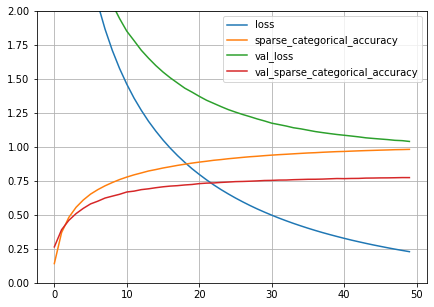

time: 196 ms (started: 2023-02-16 01:48:33 +00:00)


In [ ]:
plot_loss(history)

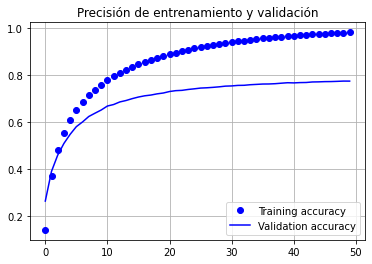

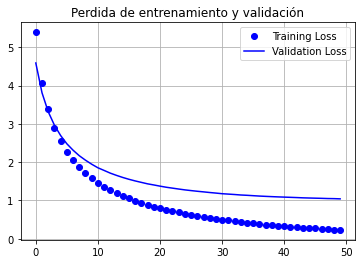

time: 365 ms (started: 2023-02-16 01:48:33 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 1.57 s (started: 2023-02-16 01:48:34 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8278341889381409
- Test Loss: 0.7717152833938599
- time: 1h 28min 56s
- F1 score: 0.8283737797403733
- Precision score: 0.8398423790446953
- Recall:  0.827834179357022
- Epoch: 50/50

Parece haberse estancado en 82%

## Cargar las imágenes

In [ ]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 586 µs (started: 2023-02-16 01:48:36 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 26.1 s (started: 2023-02-16 01:48:36 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.01 ms (started: 2023-02-16 01:49:02 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.43 s (started: 2023-02-16 01:49:02 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 118s 33ms/step - loss: 5.1662 - sparse_categorical_accuracy: 0.1702 - val_loss: 4.2992 - val_sparse_categorical_accuracy: 0.3167
Epoch 2/50
3325/3325 [==============================] - 105s 32ms/step - loss: 3.7376 - sparse_categorical_accuracy: 0.4283 - val_loss: 3.4927 - val_sparse_categorical_accuracy: 0.4540
Epoch 3/50
3325/3325 [==============================] - 104s 31ms/step - loss: 3.0299 - sparse_categorical_accuracy: 0.5484 - val_loss: 2.9815 - val_sparse_categorical_accuracy: 0.5302
Epoch 4/50
3325/3325 [==============================] - 104s 31ms/step - loss: 2.5497 - sparse_categorical_accuracy: 0.6261 - val_loss: 2.6268 - val_sparse_categorical_accuracy: 0.5805
Epoch 5/50
3325/3325 [==============================] - 103s 31ms/step - loss: 2.1955 - sparse_categorical_accuracy: 0.6799 - val_loss: 2.3512 - val_sparse_categorical_accuracy: 0.6189
Epoch 6/50
3325/3325 [==============================] - 104s 31ms/step - lo

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.71 s (started: 2023-02-16 03:18:05 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 14s 26ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8278341889381409
- Test Loss: 0.7717152833938599
- time: 
- F1 score: 0.8283737797403733
- Precision score: 0.8398423790446953
- Recall:  0.827834179357022
- Epoch: 
*********************************************************************************************************************************
time: 28 s (started: 2023-02-16 03:18:08 +00:00)


## Graficando


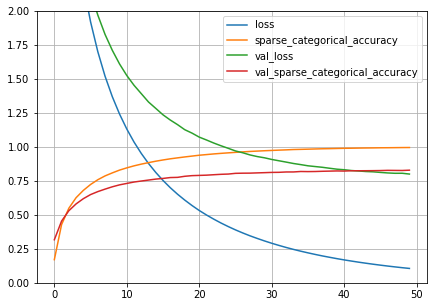

time: 199 ms (started: 2023-02-16 03:18:36 +00:00)


In [ ]:
plot_loss(history)

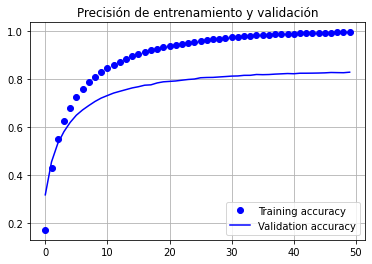

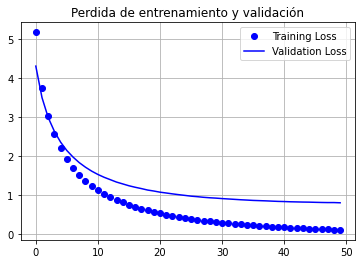

time: 396 ms (started: 2023-02-16 03:18:37 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 1.6 s (started: 2023-02-16 03:18:37 +00:00)
